# Note 3: Considering Experimental Factors in Data Splitting

## 0. Overview

We have introduced how critical a proper data splitting is in model validation. However, both notes split the data randomly without considering any experimental factors. In this note, we will dive into the details of how the splitting methods can influence our conclusions during model validation.

In [19]:
from note03 import sim_bw, vis_bw
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Simulation

To help us understand the problem, we will use a simulated dataset with a linear mixed model.

- The data records monthly body weight measurements of 30 cows over 24 months. The 30 cows were offsprints of 3 sires (10 cows per sire).

- The simulated body weight is controlled by four fixed effects: `month`, and three arbitrary predictors `X1`, `X2`, and `X3`, and one random effect `sire`.

- Additionally, there is an interaction between `month` and `sire`, which means every sire has a different growth rate over time.

In R library `lmer`, the expression is

```R
Body weight ~ Month + X1 + X2 + X3 + (1 + Month | Sire)
```

In linear algebra, we can write the same equation as follows:

$$

\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \mathbf{Z}\mathbf{u} + \boldsymbol{\epsilon} 

$$

$$
\mathbf{X}=\left[\begin{array}{c}
1 \\
x_{m} \\
x_{1} \\
x_{2} \\
x_{3}
\end{array}\right]^T,
\mathbf{\beta}=\left[\begin{array}{c}
\beta_0 \\
\beta_m \\
\beta_{x1} \\
\beta_{x2} \\
\beta_{x3}
\end{array}\right],
\mathbf{Z}=\left[\begin{array}{c}
s_1m_0\\
s_1m_1 \\
s_1m_2 \\
\vdots \\
s_3m_{23}\\
s_3m_{24}\\
\end{array}\right]^T
$$

$$

\mathbf{u} \sim \mathcal{N}(\mathbf{0}, \sigma^{2}_{u}(A_{3\times 3}
 \otimes I_{25}))
$$
$$
\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \sigma^{2}_{e} I_{n})
$$

$$

\mathbf{A}=\left[\begin{array}{ccc}

1 & 0.5 & 0 \\
0.5 & 1 & 0 \\
0 & 0 & 1

\end{array}\right]

$$

where $x_m$, $x_1$, $x_2$, and $x_3$ are the values of `month` (from 1 to 24) and the three $x$ predictors (from 0 to 1) in the incidence matrix $\mathbf{X}$, respectively. And $\mathbf{\beta}$ is the vector of fixed effects. $\mathbf{Z}$ is the incidence matrix of the random effect $\mathbf{u}$, where $s_{i}m_{j}$ (value 0 or 1) is the existence of sire $i$ in month $j$, and $s_{i}m_0$ is the random intercept of sire $i$. The covariance matrix $\mathbf{A}$ is the additive genetic relationship matrix of the three sires. The $\boldsymbol{\epsilon}$ is the vector of residuals, and
$\sigma^{2}_{u}$ and $\sigma^{2}_{e}$ are the variance of the random effect and the residual, respectively.

We have pre-defined the simulation script based on the model above. We can use `sim_bw()` to simulate the data.

--- Simulated Pedigree ---
   id  sire  dam
0   1     0    0
1   2     0    0
2   3     1    2
3   4     1    2
4   5     0    0
--------------------------


,sire,cow,month,x1,x2,x3,bw
0,3,1,1,1.656538,0.805418,-0.345144,382.616078
1,3,1,2,-0.181392,0.545937,0.058574,340.016891
2,3,1,3,-1.447216,-0.019301,0.252617,447.478866
3,3,1,4,-0.949368,-0.079939,0.174065,453.489351
4,3,1,5,-2.320341,-0.703153,0.033552,549.926962
...,...,...,...,...,...,...,...
715,5,10,20,-1.038887,1.361877,0.990443,2101.192887
716,5,10,21,1.164137,0.130880,1.298478,2252.745179
717,5,10,22,0.468165,1.542397,0.628442,2247.765732
718,5,10,23,1.269726,0.052170,-1.150353,1720.082172


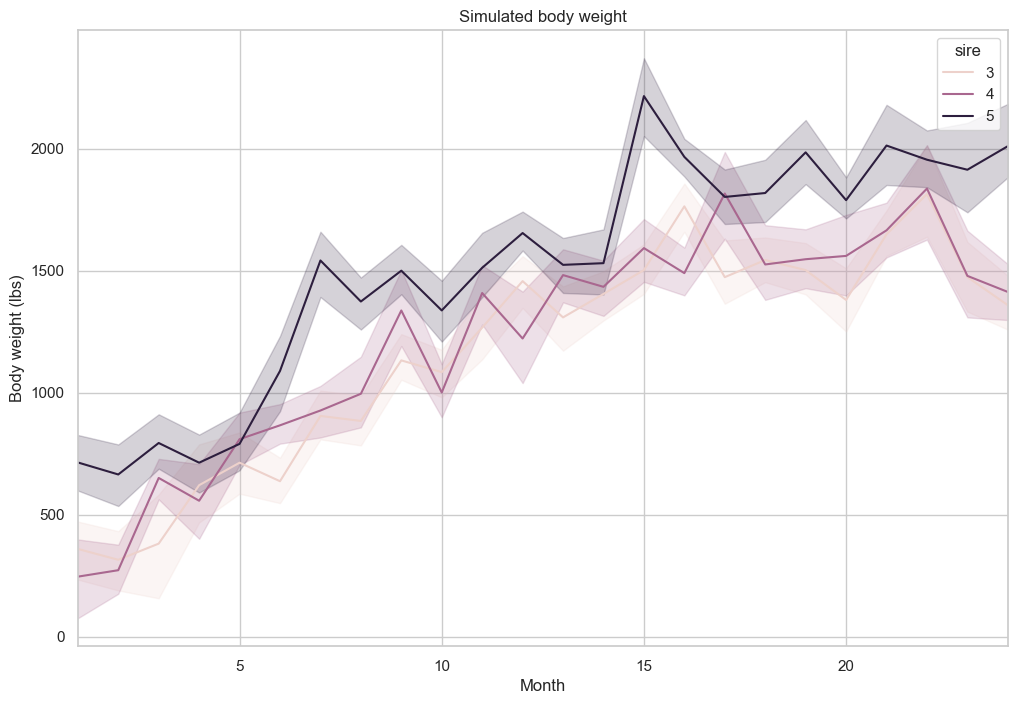

In [13]:
# np.random.seed(0)
data = sim_bw(sdu=100, sde=50)
vis_bw(data)
display(data)

## 2. Splitting Methods

We can consider our dataset as a 3 by 24 matrix, where each row is a sire and each column is a month. Hence, it gives us two ways to split the data: by rows (sires) or by columns (months). Including the previous random splitting, we have three splitting methods in this note:

- Method A: Randonly choose 80% of the data as training set and 20% as testing set.

- Method B: Use the first 16 months as training set and the last 8 months as testing set.

- Method C: Use the first 2 sires as training set and the last sire as testing set.

<img src="res/note03_split.png" width="800"/>

In [93]:
n = len(data)
n_train = int(0.8 * n)
# method A
data_shuffled = data.sample(frac=1)
data_train_A = data_shuffled.iloc[:n_train]
data_test_A = data_shuffled.iloc[n_train:]
# method B
data_train_B = data.query("month <= 16")
data_test_B = data.query("month > 16")
# method C
data_train_C = data.query("sire != 5")
data_test_C = data.query("sire == 5")

## 3. Model Fitting

To demonstrate how the splitting methods influence our model validation, we intentionally use a linear model that only considers the fixed effects:

$$

\mathbf{bw} \sim month + x_1 + x_2 + x_3 + \boldsymbol{\epsilon}


$$

Here we use the `method A` as an example.


In [36]:
# learn coefficients from the training ste
model_ols = smf.ols("bw ~ month + x1 + x2 + x3", data_train_A).fit()
print(model_ols.params)
# predict on the testing set
data_test_A.loc[:, "bw_pre"] = model_ols.predict(data_test_A)
obs = data_test_A["bw"]
pre = data_test_A["bw_pre"]
# evaluation
r = pearsonr(obs, pre)[0].round(3)
mse = mean_squared_error(obs, pre).round(3)
print("correlation: ", r)
print("mse: ", mse)

Intercept    529.633011
month         59.959276
x1            44.007603
x2           103.364081
x3           187.745855
dtype: float64
correlation:  0.892
mse:  55518.122


Visualize the result

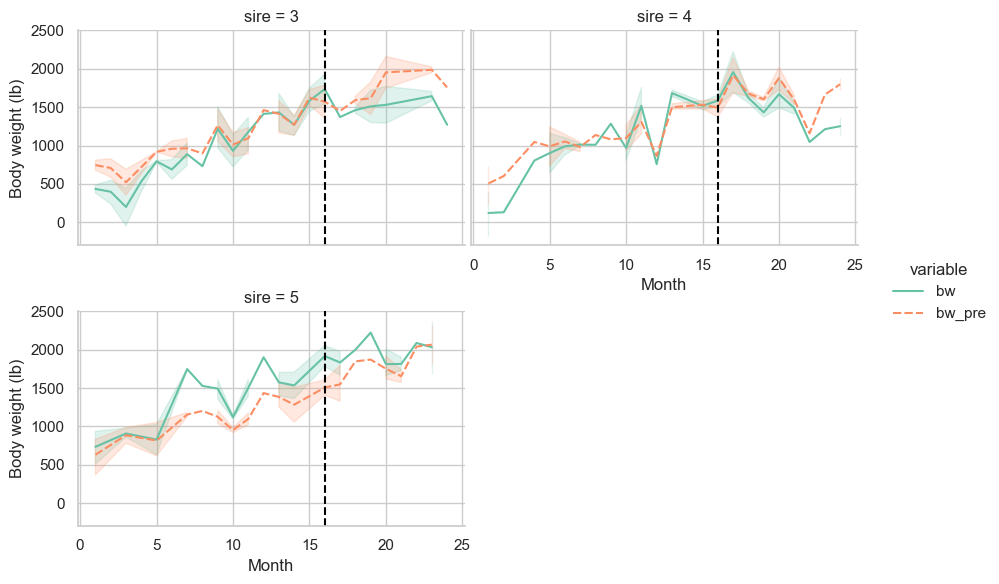

In [73]:
data_plot = data_test_A.melt(id_vars=["sire", "month"], value_vars=["bw", "bw_pre"])
plot = sns.relplot(x="month", y="value", hue="variable", style="variable",
            col="sire", col_wrap=2, kind="line",
            height=3, aspect=1.5,
            data=data_plot)
(plot.map(plt.axvline, x=16, color="k", linestyle="--")
  .set_axis_labels("Month", "Body weight (lb)")
  .tight_layout(w_pad=0))

Text(0, 0.5, 'Predicted body weight (lbs)')

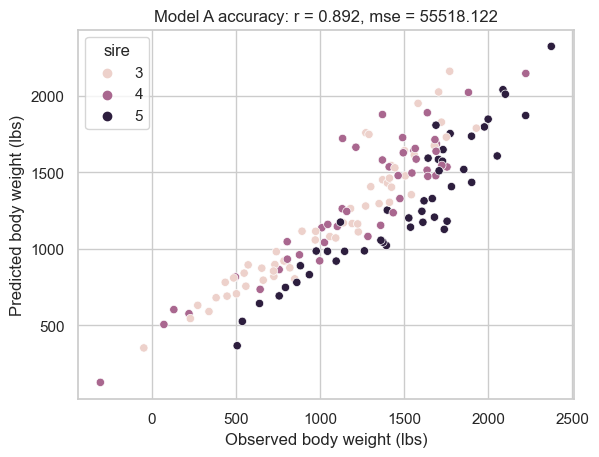

In [74]:
sns.scatterplot(x="bw", y="bw_pre", hue="sire", data=data_test_A)
plt.title(f"Model A accuracy: r = {r}, mse = {mse}")
plt.xlabel("Observed body weight (lbs)")
plt.ylabel("Predicted body weight (lbs)")


## 4. Comparison

### 4.1 Functions

Now we can extend the same procedure to the other two splitting methods and compare the results. Let's wrap the code above into a functions

In [82]:
def fit_and_predict(data_train, data_test):
    # learn coefficients from the training ste
    model_ols = smf.ols("bw ~ month + x1 + x2 + x3", data_train).fit()
    # predict on the testing set
    data_test.loc[:, "bw_pre"] = model_ols.predict(data_test)
    # evaluation
    obs = data_test["bw"]
    pre = data_test["bw_pre"]
    # evaluation
    r = pearsonr(obs, pre)[0].round(3)
    mse = mean_squared_error(obs, pre).round(3)
    # print results
    print(f"r = {r}, mse = {mse}")
    return data_test, r, mse

def vis_linechart(data_test):
    data_plot = data_test.melt(id_vars=["sire", "month"], value_vars=["bw", "bw_pre"])
    plot = sns.relplot(x="month", y="value", hue="variable", style="variable",
                col="sire", col_wrap=2, kind="line",
                height=3, aspect=1.5,
                data=data_plot)
    (plot.map(plt.axvline, x=16, color="k", linestyle="--")
      .set_axis_labels("Month", "Body weight (lb)")
      .tight_layout(w_pad=0))

def vis_obspre(data_test, r, mse):
    sns.scatterplot(x="bw", y="bw_pre", hue="sire", data=data_test)
    plt.title(f"Model accuracy: r = {r}, mse = {mse}")
    plt.xlabel("Observed body weight (lbs)")
    plt.ylabel("Predicted body weight (lbs)")

### 4.2 Method A: Random Splitting

In [80]:
data_test_A, r_A, mse_A = fit_and_predict(data_train_A, data_test_A)

r = 0.892, mse = 55518.122


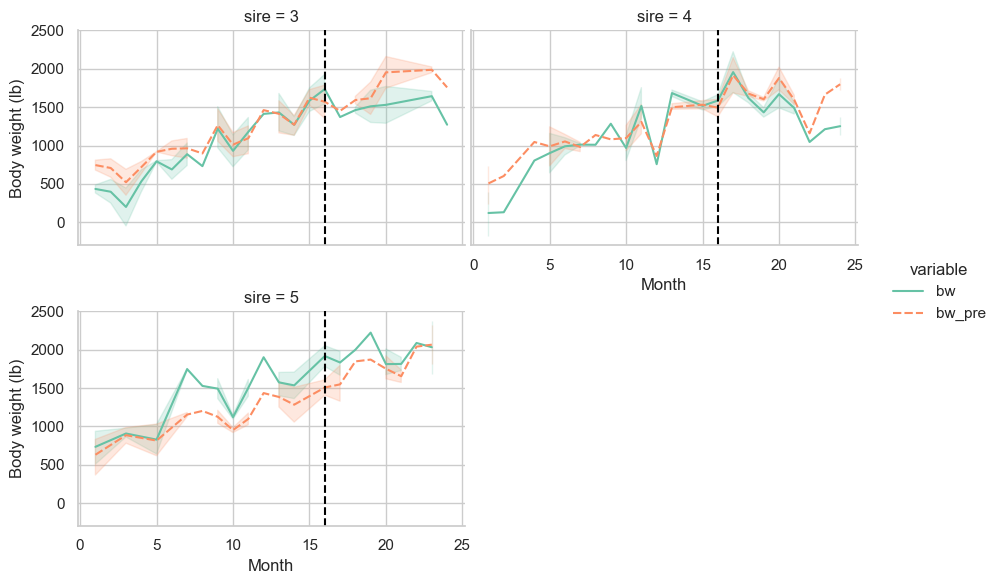

In [83]:
vis_linechart(data_test_A)

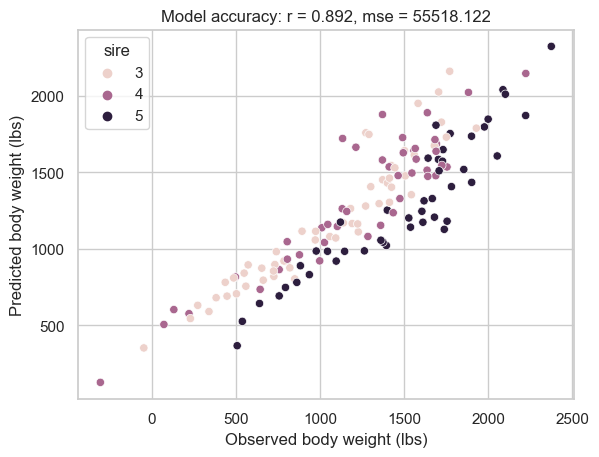

In [84]:
vis_obspre(data_test_A, r_A, mse_A)

### 4.3: Method B: Splitting by Months

In [86]:
data_test_B, r_B, mse_B = fit_and_predict(data_train_B, data_test_B)

r = 0.576, mse = 301545.763


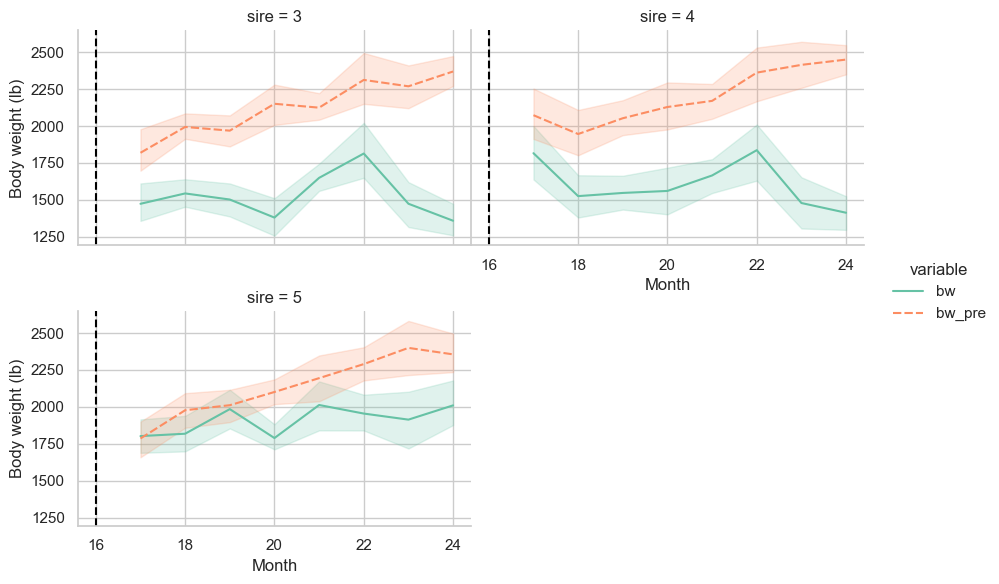

In [87]:
vis_linechart(data_test_B)

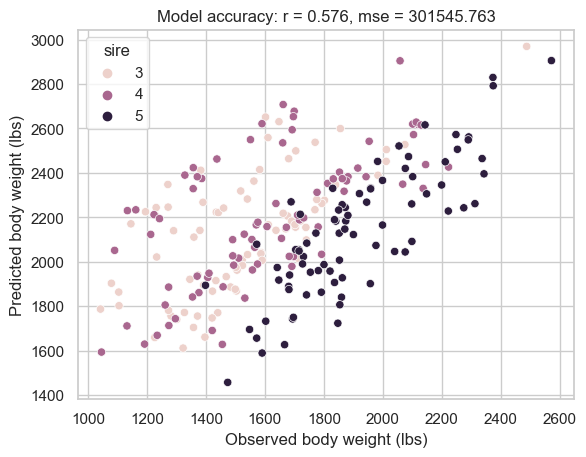

In [88]:
vis_obspre(data_test_B, r_B, mse_B)

### 4.4 Method C: Splitting by Sires

In [96]:
data_test_C, r_C, mse_C = fit_and_predict(data_train_C, data_test_C)

r = 0.929, mse = 157241.376


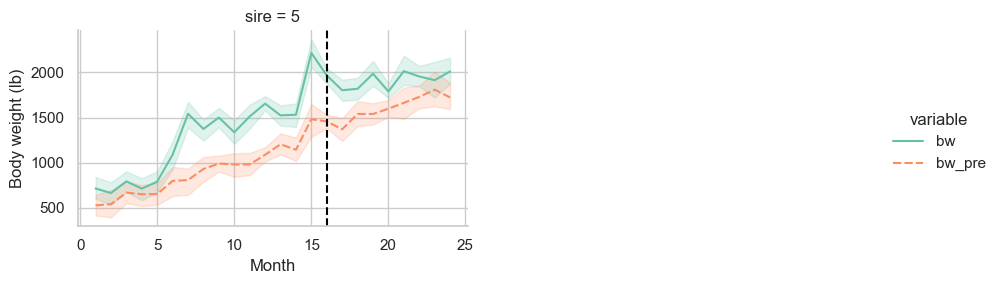

In [98]:
vis_linechart(data_test_C)

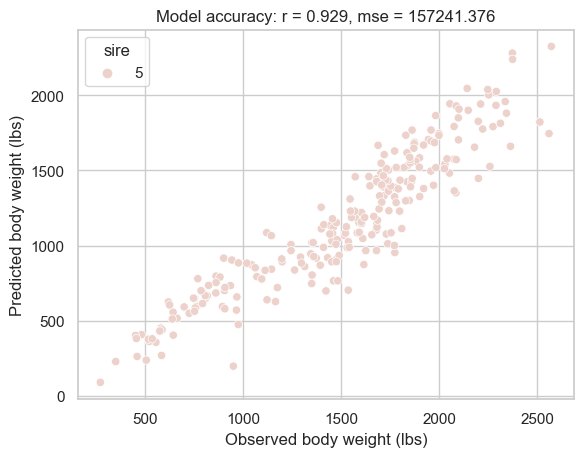

In [97]:
vis_obspre(data_test_C, r_C, mse_C)